In [48]:
using Pkg;
# Pkg.add("ReactionNetworkImporters");
# Pkg.add("Dictionaries");
# Pkg.add("LaTeXStrings");
# Pkg.add("Statistics");
# Pkg.add("ColorSchemes");
# Pkg.add("IterTools"); 
# Pkg.add("NNlib"); 
# Pkg.add("DifferentialEquations");
# # Pkg.add("Plots");
# Pkg.add("Formatting");
# Pkg.add("LinearAlgebra");
# Pkg.add("Noise");
# Pkg.add("Catalyst");

using DifferentialEquations;
using Random;
# using Plots;
using Formatting;
using LinearAlgebra;
using Noise;
using ReactionNetworkImporters;
using Dictionaries;
using LaTeXStrings;
using Statistics;
using ColorSchemes;
using Catalyst;
using IterTools;
using NNlib;

nothing

In [49]:
include("datasets.jl")
train = create_annular_rings_dataset(150)
val = create_annular_rings_dataset(50)

51-element Vector{Any}:
 Float32[0.08842449 0.29165784 -1.0]
 Float32[-0.5503854 -1.1149971 1.0]
 Float32[0.55548507 0.99515015 1.0]
 Float32[-0.769162 -0.9782085 1.0]
 Float32[0.20719677 -1.4131434 1.0]
 Float32[-0.24184017 0.0024189884 -1.0]
 Float32[0.86317176 0.7478409 1.0]
 Float32[-1.3057988 0.48281604 1.0]
 Float32[0.004497695 0.026224501 -1.0]
 Float32[-0.30146328 1.3891264 1.0]
 ⋮
 Float32[-0.3249759 -1.0760043 1.0]
 Float32[-0.35018557 -0.106284656 -1.0]
 Float32[0.24567488 0.2457594 -1.0]
 Float32[-0.24695767 -1.2209243 1.0]
 Float32[-0.1787239 -1.0597765 1.0]
 Float32[0.07216905 0.44303387 -1.0]
 Float32[0.20813894 0.44447502 -1.0]
 Float32[0.79327464 0.93108153 1.0]
 Float32[0.93513143 0.49577358 1.0]

In [50]:

include("utils.jl")

nothing

In [51]:
1/sqrt(3)*rand(-2:2, 3, 3)

3×3 Matrix{Float64}:
 -1.1547   -1.1547   0.0
  0.57735  -1.1547   1.1547
  0.0       1.1547  -0.57735

In [52]:
DIMS=3
params_orig = create_node_params(DIMS, t0=0.0, t1=3.0)
# params_orig = [3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 1.0]

19-element Vector{Any}:
  3
  0.1
  0.1
  0.1
  0.1
  0.1
  0.1
  0.1
  0.1
  0.1
  0.1
  0.1
  0.1
  0.1991094786
  0.9017906394
 -0.2206646325
  0.1
  0.0
  3.0

In [53]:
function f(u, xAndp, t)
    x = xAndp[1:3]
    p = xAndp[4:end]
    _, theta, beta, w, h, _, _ = sequester_params(p)
 
    hvec = ones(length(u))*h
    fmat = (theta*x + beta).*u - u.*u + hvec
    return fmat
end

function forward!(du, u, xAndp, t)
    x = xAndp[1:3]
    p = xAndp[4:end]
    dims, theta, beta, w, h, _, _ = sequester_params(p)
    fmat = f(u, xAndp, t)
    for i in 1:length(fmat)
        du[i] = fmat[i]
    end
end


# Calculates the final hidden state of the neural ode
function forward_node(u0, xAndp, tspan)
    prob = ODEProblem(forward!, u0, tspan, xAndp)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, maxiters=1e5)
    return sol
end


function backward!(du, u, sAndp, t)
    s = sAndp[1:3]
    p = sAndp[4:end]
    dims, theta, beta, w, h, _, _ = sequester_params(p)
    fmat = -f(u, sAndp, t)
    for i in 1:length(fmat)
        du[i] = fmat[i]
    end
end


function backward_node(s0, sAndp, tspan)
    prob = ODEProblem(backward!, s0, tspan, sAndp)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, maxiters=1e5)
    return sol
end

backward_node (generic function with 1 method)

ODE | Input: [1.025242066383362, 0.0898539274930954, 0.1] | Target: -1.0
params before | Any[3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1991094786, 0.9017906394, -0.2206646325, 0.1, 0.0, 3.0]
Ideal ReLU | [1.2467516657710078, 0.3113635268807411, 0.3215095993876458]
ODE | z at t=T | [0.4901933971064408, 0.35751876446388703, 0.3620693225295739]
ODE | Input: [1.025242066383362, 0.0898539274930954, 0.1] 
ODE | z at t=0 | [1.032544905713375; 0.09040185533180238; 0.10058368480413592;;]
[0.4901933971064408, 

0.35751876446388703, 0.3620693225295739]

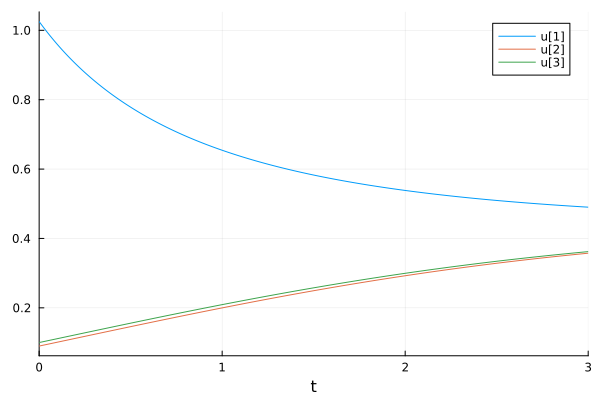

In [54]:
function node_main(params, train, val; DIMS=3, EPOCHS=20, LR=0.001, threshold=nothing)
    for trindex in eachindex(train)
        x, y = get_one(train, trindex)
        # Augment
        x = augment(x, DIMS-length(x))

        for i in eachindex(x)
            x[i] = abs(x[i])
        end
        x[3] = 0.1
        x = [1.02524206638336182, 0.0898539274930954, 0.1]
        println("ODE | Input: $x | Target: $y")
        dims, theta, beta, w, h, t0, t1 = sequester_params(params)
        
        println("params before | ", params)
        xAndp = vcat(x, params)
        tspan = (t0, t1)
        sol = forward_node(x, xAndp, tspan)
        println("Ideal ReLU | ", relu.(x+theta*x + beta))
        println("ODE | z at t=T | ", sol[end])

        z = reshape(sol[end], (DIMS, 1)) 
        s0 = z
        sAndp = vcat(s0, params)
        rtspan = reverse(tspan)
        bsol = backward_node(s0, sAndp, tspan)
        println("ODE | Input: $x ")
        println("ODE | z at t=0 | ", bsol[end])
        println("==================================")
        return sol, bsol
    end
    
end

function neuralode(; DIMS=3)
    # train = create_linearly_separable_dataset(100, linear, threshold=0.0)
    # val = create_linearly_separable_dataset(40, linear, threshold=0.0)
    # val = train   
    sol, bsol = node_main(params_orig, train[1:1], val[1:1], DIMS=DIMS, EPOCHS=30, threshold=0.0, LR=0.001)
    return sol, bsol
end

sol, bsol = neuralode()
print(sol[end])
plot(sol)